In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from datetime import timedelta

database = pd.read_csv('database.csv')
saldo_iniziale_conti = pd.read_csv('Datathon_2025_Saldi_Storici_Conto_Corrente_CSV_Corrected.csv')
saldo_iniziale_conti.dropna(inplace=True)
database["data_contabile"] = pd.to_datetime(database["data_contabile"])
database['DESCRIZIONE'] = database['DESCRIZIONE'].str.strip()

/var/tmp/ipykernel_6340/3120428364.py:9: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  database = pd.read_csv('database.csv')


Inserisci il codice idetificativo dall'Azienda che vuoi analizzare: 


 57


L'Azienda con ID: 57 ha un numero di osservazioni complessive pari a: 13444, che interessano 518 giorni.
Il primo spostamento risale al: 2023-02-15
L'ultimo spostamento risale al: 2025-02-17
Il numero di conti coinvolti è pari a: 2, e lo stato della Liquidità Complessiva è di: 1237926.6199999999 €


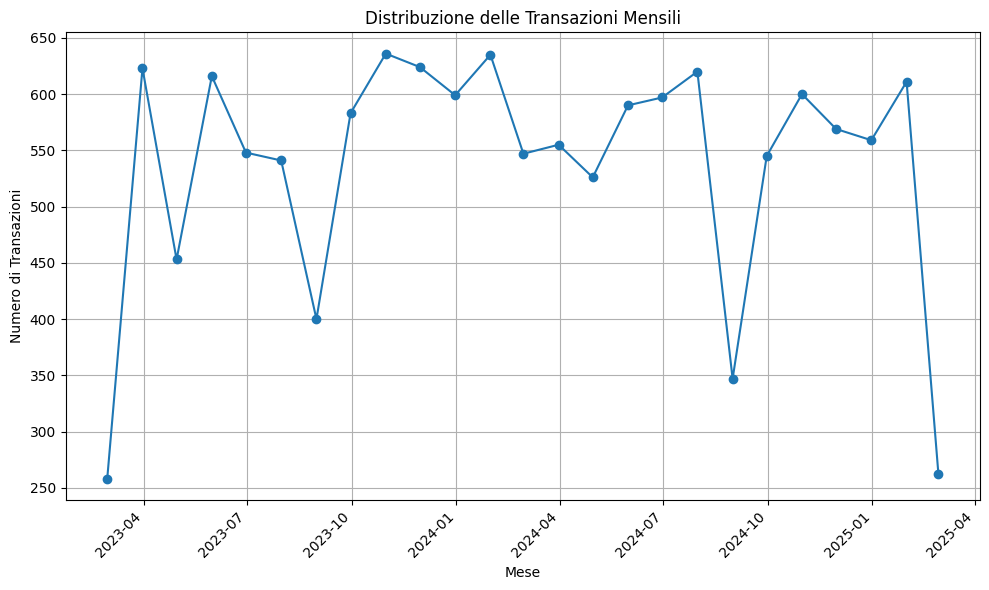

In [2]:
#Scelta Azienda Singola + Info
print("Inserisci il codice idetificativo dall'Azienda che vuoi analizzare: ")
x=int(input())
DB = database[database['Azienda'] == x].copy()
DB['Id_conto'] = DB['Id_conto'].astype(int)
saldo_iniziale_df = saldo_iniziale_conti.copy()
saldo_iniziale_df['Id_conto'] = saldo_iniziale_df['Id_conto'].astype(int)
Saldo_Conto = saldo_iniziale_df.merge(DB['Id_conto'].value_counts(), on='Id_conto', how='left')
Saldo_Conto.dropna(inplace=True)
saldo_iniziale = Saldo_Conto['saldo'].sum()
print(f"L'Azienda con ID: {x} ha un numero di osservazioni complessive pari a: {len(DB)}, che interessano {len(DB.value_counts('data_contabile'))} giorni.")
print(f"Il primo spostamento risale al: {DB['data_contabile'].dt.date.min()}")
print(f"L'ultimo spostamento risale al: {DB['data_contabile'].dt.date.max()}")
if saldo_iniziale == 0:
  saldo_iniziale = 500000
  print(f"Il numero di conti coinvolti è pari a: {len(Saldo_Conto)}, dato sul saldo inesistente. Liquidità Complessiva Ipotizzata: {saldo_iniziale} €")
else:
  print(f"Il numero di conti coinvolti è pari a: {len(Saldo_Conto)}, e lo stato della Liquidità Complessiva è di: {saldo_iniziale} €")

# Raggruppamento per mese anziché per giorno
distr_causali_mesi = DB.groupby(pd.Grouper(key='data_contabile', freq='ME'))['data_contabile'].count().reset_index(name='Numero_Transazioni')
distr_causali_mesi.columns = ['data_contabile', 'Numero_Transazioni']

# Creazione del grafico con i dati mensili
plt.figure(figsize=(10, 6))
plt.plot(distr_causali_mesi['data_contabile'], distr_causali_mesi['Numero_Transazioni'], marker='o', linestyle='-')
plt.title('Distribuzione delle Transazioni Mensili')
plt.xlabel('Mese')
plt.ylabel('Numero di Transazioni')
plt.grid(True)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
# Aziende_Cluster = [57,67,71,74,299,342,2630,378]
# 57: ok, 67: ok, 71: ok, 74: ok, 299: ok, 342: ok, 2630: ok, 378: storta ma ok!

L'Azienda con ID: 57, ha le seguenti caratteristiche:
Il numero di spostamenti in uscita è: 7101.
Il numero di osservazioni accorpate in singoli giorni è: 499!
Grafico Uscite per Mese!


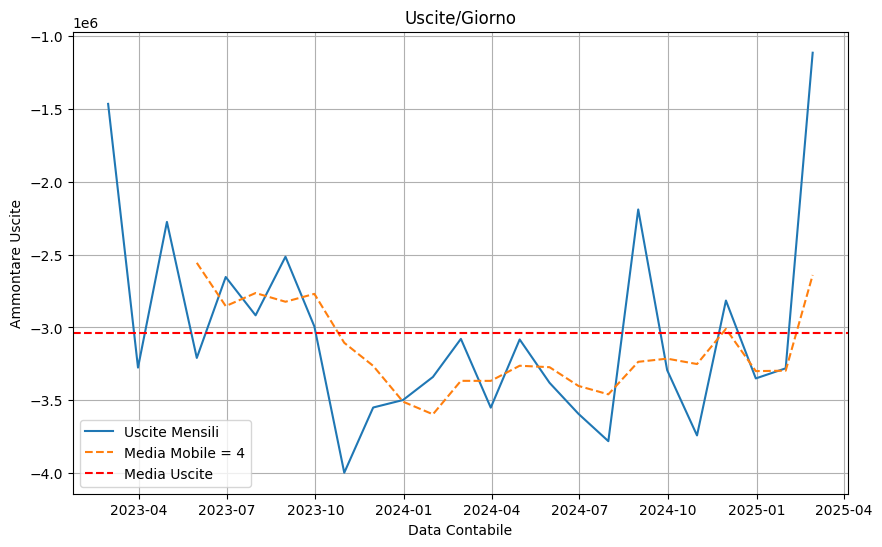

I cinque movimenti più frequenti sono:
PAGAMENTI DIVERSI, n = 2383
COMMISSIONI, n = 2080
DISPOSIZIONI DIVERSE, n = 1328
EFFETTI RITIRATI, n = 640
IMPOSTE E TASSE, n = 226


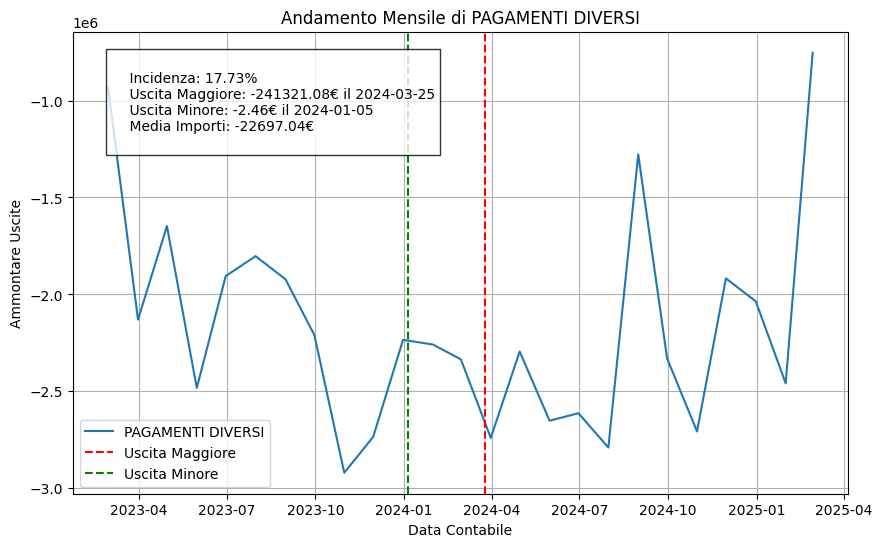

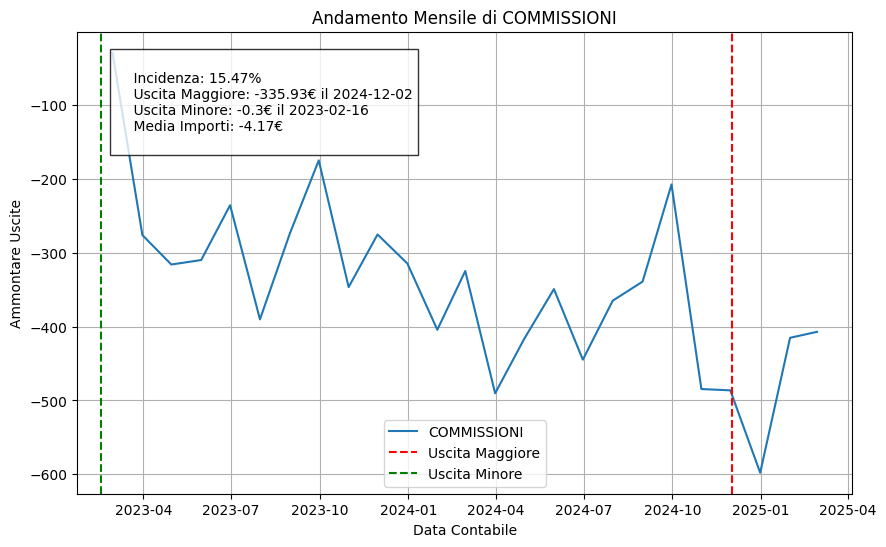

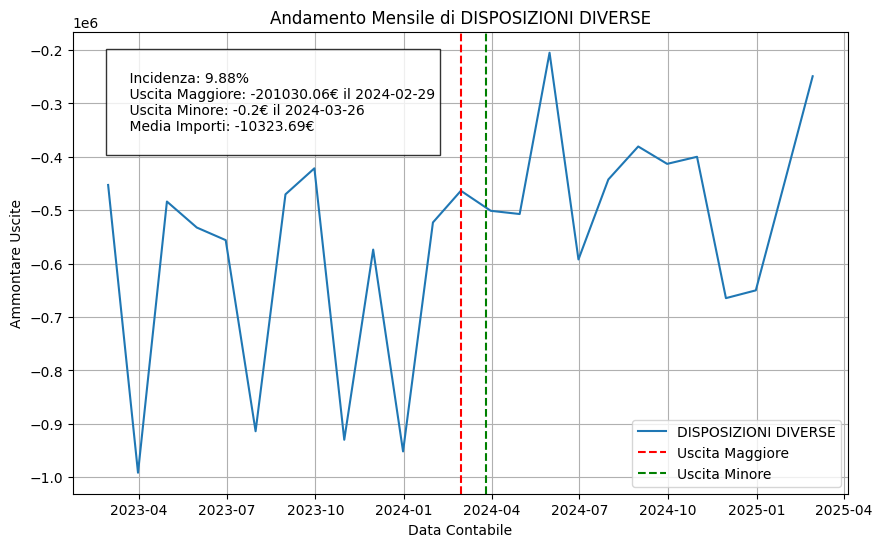

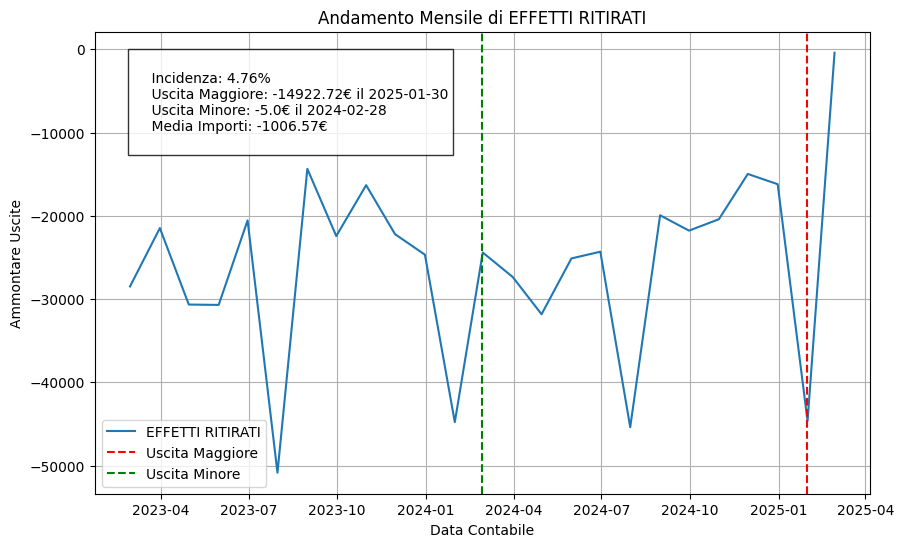

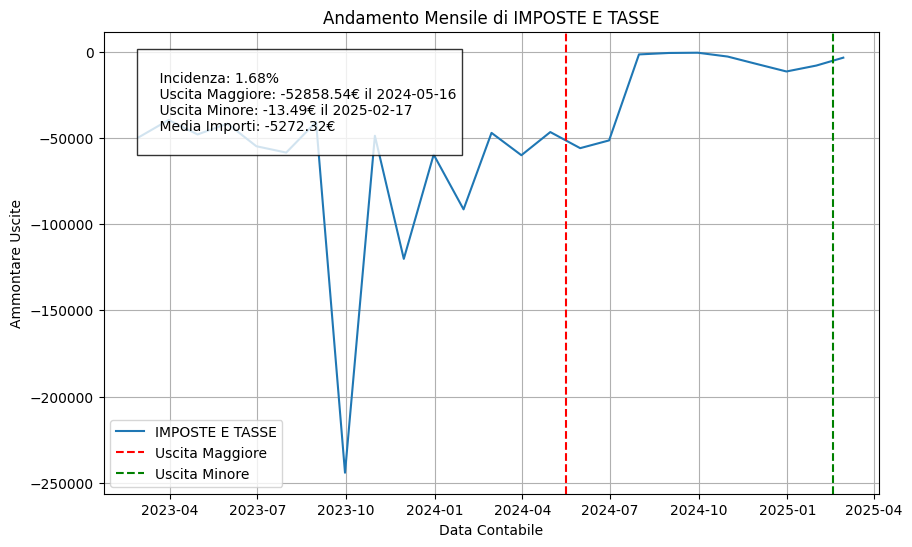

In [3]:
#Divisione DB - Uscite
print(f"L'Azienda con ID: {x}, ha le seguenti caratteristiche:")
DB_Uscite = DB[DB['Importo'] < 0]
print(f"Il numero di spostamenti in uscita è: {len(DB_Uscite)}.")
DB_Uscite_giornaliero = DB_Uscite.groupby(DB_Uscite['data_contabile'].dt.date)['Importo'].sum().reset_index()
print(f"Il numero di osservazioni accorpate in singoli giorni è: {len(DB_Uscite_giornaliero)}!")

print(f"Grafico Uscite per Mese!")
DB_Uscite_mensile = DB_Uscite.groupby(pd.Grouper(key='data_contabile', freq='ME'))['Importo'].sum().reset_index()
DB_Uscite_mensile["Rolling_Mean"] = DB_Uscite_mensile['Importo'].rolling(window=4).mean()
media_uscite = DB_Uscite_mensile['Importo'].mean()
plt.figure(figsize=(10, 6))
plt.plot(DB_Uscite_mensile['data_contabile'], DB_Uscite_mensile['Importo'], label='Uscite Mensili')
plt.plot(DB_Uscite_mensile['data_contabile'], DB_Uscite_mensile['Rolling_Mean'], label='Media Mobile = 4', linestyle='--')
plt.axhline(y=media_uscite, color='r', linestyle='--', label='Media Uscite')
plt.xlabel('Data Contabile')
plt.ylabel('Ammontare Uscite')
plt.title('Uscite/Giorno')
plt.legend()
plt.grid(True)
plt.show()

#Uscite più frequenti
DB_Uscite_countCausali = DB_Uscite.groupby('DESCRIZIONE')['Importo'].count().reset_index()
DB_Uscite_countCausali = DB_Uscite_countCausali.sort_values(by=['Importo'], ascending=False)
DB_Uscite_countCausali = DB_Uscite_countCausali.rename(columns={'Importo': 'Frequenza'})

print("I cinque movimenti più frequenti sono:")
for index, row in DB_Uscite_countCausali.head(5).iterrows():
    print(f"{row['DESCRIZIONE']}, n = {row['Frequenza']}")

# Grafico dell'andamento delle prime 5 principali Uscite
top_5_descriptions = DB_Uscite_countCausali.head(5)['DESCRIZIONE'].tolist()
filtered_expenses = DB_Uscite[DB_Uscite['DESCRIZIONE'].isin(top_5_descriptions)]
monthly_expenses_by_description = filtered_expenses.groupby([pd.Grouper(key='data_contabile', freq='ME'), 'DESCRIZIONE'])['Importo'].sum().reset_index()

# Calcolo informazioni aggiuntive per i commenti
total_transactions = len(DB)  # Numero totale di spostamenti

for description in top_5_descriptions:
    plt.figure(figsize=(10, 6))  # Create a new figure for each plot
    data = monthly_expenses_by_description[monthly_expenses_by_description['DESCRIZIONE'] == description]

    # Calcolo incidenza, valore massimo, giorno del valore massimo, valore minimo, giorno del valore minimo e media
    incidence = (len(filtered_expenses[filtered_expenses['DESCRIZIONE'] == description]) / total_transactions) * 100
    max_value = filtered_expenses[filtered_expenses['DESCRIZIONE'] == description]['Importo'].min()
    max_value_date = filtered_expenses[filtered_expenses['DESCRIZIONE'] == description].loc[filtered_expenses[filtered_expenses['DESCRIZIONE'] == description]['Importo'] == max_value, 'data_contabile'].dt.date.iloc[0]
    min_value = filtered_expenses[filtered_expenses['DESCRIZIONE'] == description]['Importo'].max()
    min_value_date = filtered_expenses[filtered_expenses['DESCRIZIONE'] == description].loc[filtered_expenses[filtered_expenses['DESCRIZIONE'] == description]['Importo'] == min_value, 'data_contabile'].dt.date.iloc[0]
    average_amount = filtered_expenses[filtered_expenses['DESCRIZIONE'] == description]['Importo'].mean()

    # Creazione del commento
    comment = f"""
    Incidenza: {incidence:.2f}%
    Uscita Maggiore: {max_value}€ il {max_value_date}
    Uscita Minore: {min_value}€ il {min_value_date}
    Media Importi: {average_amount:.2f}€
    """

    # Aggiunta del commento al grafico
    plt.plot(data['data_contabile'], data['Importo'], label=description)
    plt.text(0.05, 0.95, comment, transform=plt.gca().transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))

    # **Aggiunta linee verticali per i valori più significativi**
    plt.axvline(x=pd.to_datetime(max_value_date), color='red', linestyle='--', label='Uscita Maggiore')
    plt.axvline(x=pd.to_datetime(min_value_date), color='green', linestyle='--', label='Uscita Minore')

    plt.xlabel('Data Contabile')
    plt.ylabel('Ammontare Uscite')
    plt.title(f'Andamento Mensile di {description}')
    plt.legend()
    plt.grid(True)
    plt.show()



L'Azienda con ID: 57, ha le seguenti caratteristiche:
Il numero di spostamenti in entrata è: 6343
Il numero di osservazioni accorpate in singoli giorni è: 515!
Grafico Entrate per Mese!


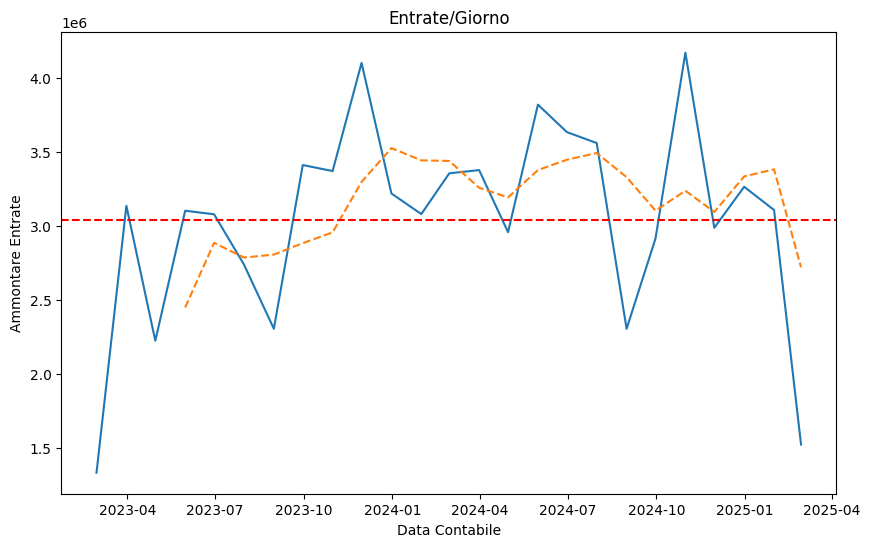

I cinque movimenti più frequenti sono:
BONIFICO A VS FAVORE,n = 4293
INCASSO TRAMITE P.O.S.,n = 689
VERSAMENTO CONTANTI/VAL.ASSIM.,n = 502
VERSAMENTO DI ASSEGNI BANCARI,n = 455
VERSAMENTO DI ASSEGNI CIRCOLARI EMESSI DA ALTRE BANCHE,n = 136


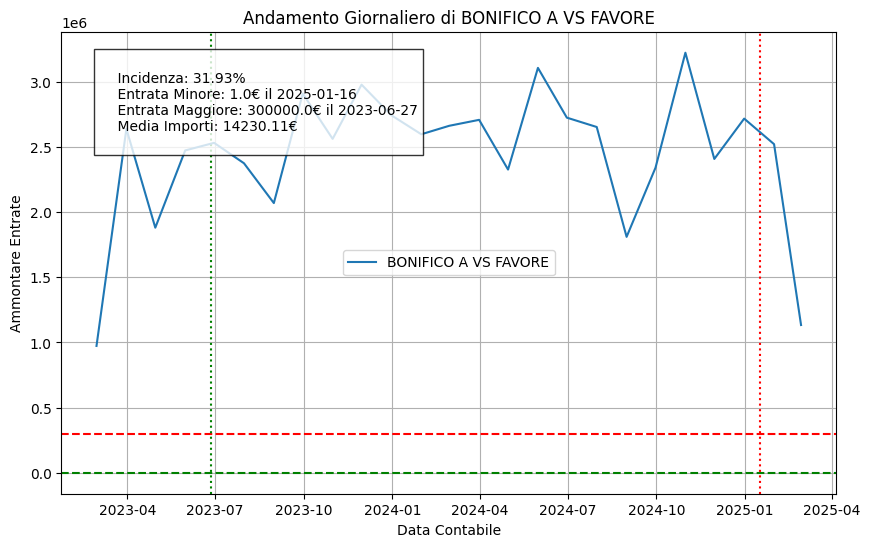

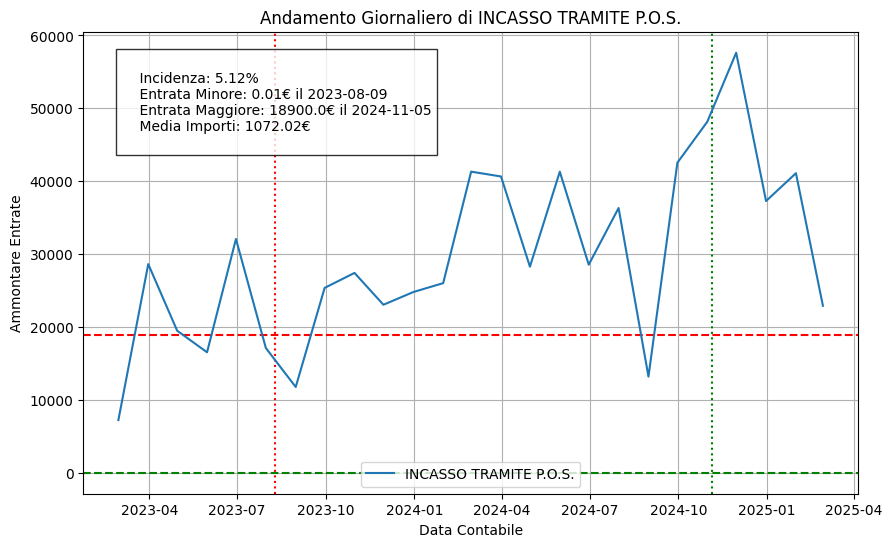

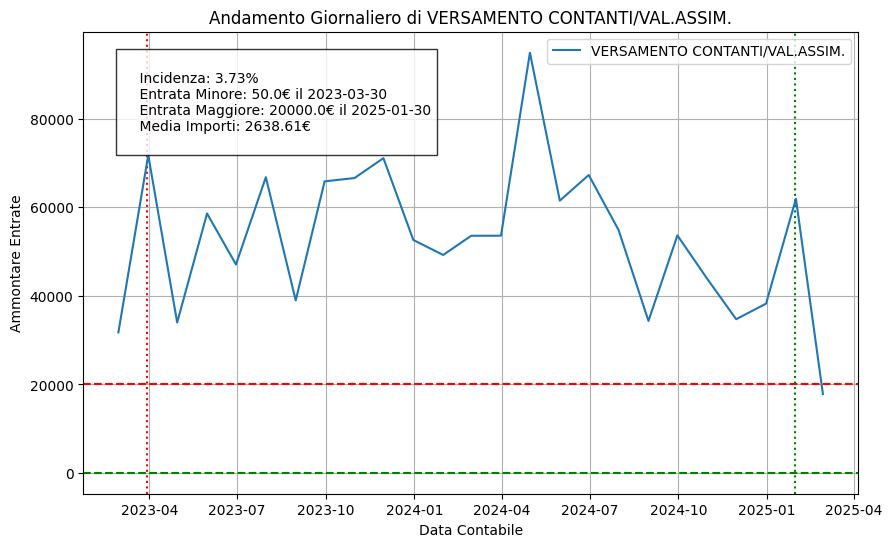

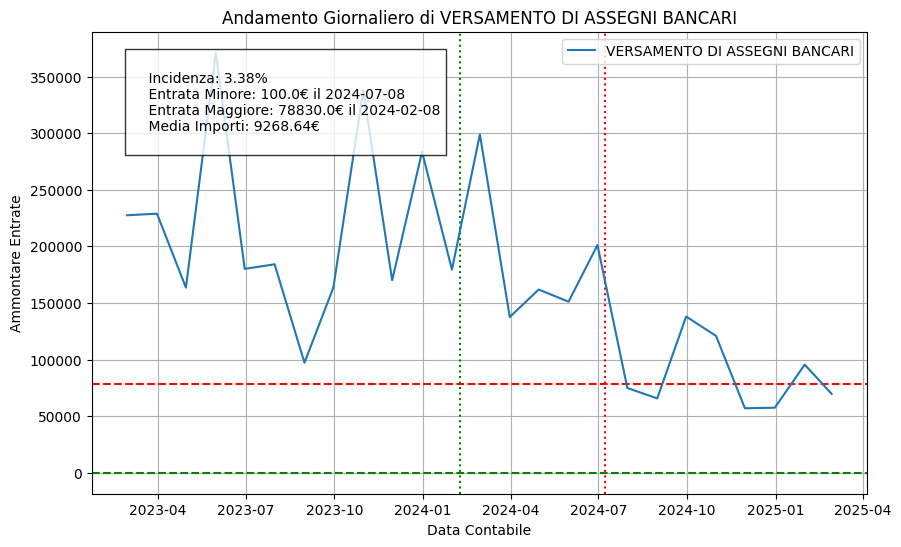

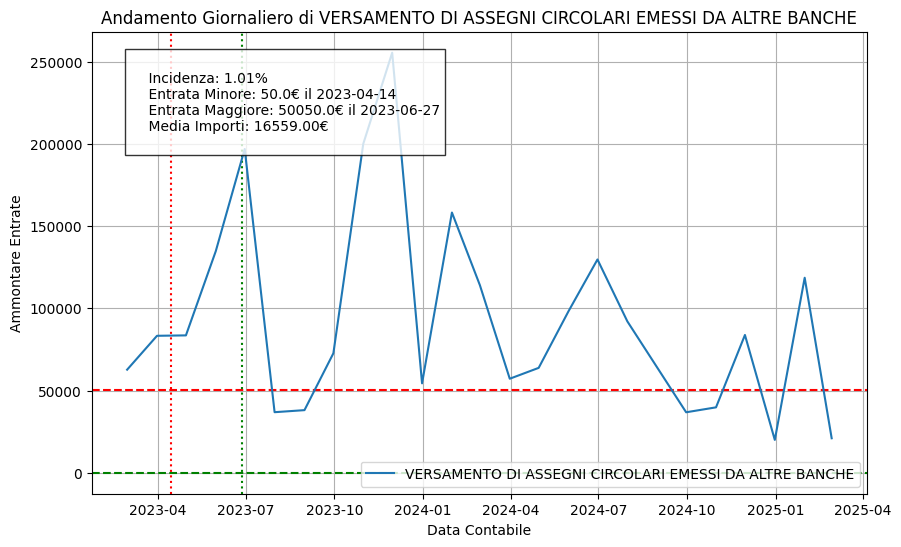

In [4]:
#Divisione DB - Entrate
print(f"L'Azienda con ID: {x}, ha le seguenti caratteristiche:")
DB_Entrate = DB[DB['Importo'] > 0]
print(f"Il numero di spostamenti in entrata è: {len(DB_Entrate)}")
DB_Entrate_giornaliero = DB_Entrate.groupby(DB_Entrate['data_contabile'].dt.date)['Importo'].sum().reset_index()
print(f"Il numero di osservazioni accorpate in singoli giorni è: {len(DB_Entrate_giornaliero)}!")

print(f"Grafico Entrate per Mese!")
DB_Entrate_mensile = DB_Entrate.groupby(pd.Grouper(key='data_contabile', freq='ME'))['Importo'].sum().reset_index()
media_entrate = DB_Entrate_mensile['Importo'].mean()
plt.figure(figsize=(10, 6))
plt.plot(DB_Entrate_mensile['data_contabile'], DB_Entrate_mensile['Importo'], label='Entrate Mensili')
plt.plot(DB_Entrate_mensile['data_contabile'], DB_Entrate_mensile['Importo'].rolling(window=4).mean(), label='Media Mobile = 4', linestyle='--')
plt.axhline(y=media_entrate, color='r', linestyle='--', label='Media Entrate')
plt.xlabel('Data Contabile')
plt.ylabel('Ammontare Entrate')
plt.title('Entrate/Giorno')
plt.show()

#Entrate più frequenti
DB_Entrate_countCausali = DB_Entrate.groupby('DESCRIZIONE')['Importo'].count().reset_index()
DB_Entrate_countCausali = DB_Entrate_countCausali.sort_values(by=['Importo'], ascending=False)
DB_Entrate_countCausali = DB_Entrate_countCausali.rename(columns={'Importo': 'Frequenza'})

print("I cinque movimenti più frequenti sono:")
for index, row in DB_Entrate_countCausali.head(5).iterrows():
    print(f"{row['DESCRIZIONE']},n = {row['Frequenza']}")

# Grafico dell'andamento delle prime 5 principali Entrate
top_5_descriptions = DB_Entrate_countCausali.head(5)['DESCRIZIONE'].tolist()
filtered_incomes = DB_Entrate[DB_Entrate['DESCRIZIONE'].isin(top_5_descriptions)]

# Modifica: Aggregazione mensile invece che giornaliera
monthly_incomes_by_description = filtered_incomes.groupby([pd.Grouper(key='data_contabile', freq='ME'), 'DESCRIZIONE'])['Importo'].sum().reset_index()

# Calcolo informazioni aggiuntive per i commenti
total_transactions = len(DB)  # Numero totale di spostamenti

for description in top_5_descriptions:
    plt.figure(figsize=(10, 6))
    data = monthly_incomes_by_description[monthly_incomes_by_description['DESCRIZIONE'] == description] # Modifica: Utilizzo monthly_incomes_by_description

    # Calcolo incidenza, valore massimo, giorno del valore massimo, valore minimo, giorno del valore minimo e media
    incidence = (len(filtered_incomes[filtered_incomes['DESCRIZIONE'] == description]) / total_transactions) * 100
    max_value = filtered_incomes[filtered_incomes['DESCRIZIONE'] == description]['Importo'].max()
    max_value_date = filtered_incomes[filtered_incomes['DESCRIZIONE'] == description].loc[filtered_incomes[filtered_incomes['DESCRIZIONE'] == description]['Importo'] == max_value, 'data_contabile'].dt.date.iloc[0]
    min_value = filtered_incomes[filtered_incomes['DESCRIZIONE'] == description]['Importo'].min()
    min_value_date = filtered_incomes[filtered_incomes['DESCRIZIONE'] == description].loc[filtered_incomes[filtered_incomes['DESCRIZIONE'] == description]['Importo'] == min_value, 'data_contabile'].dt.date.iloc[0]
    average_amount = filtered_incomes[filtered_incomes['DESCRIZIONE'] == description]['Importo'].mean()

    # Creazione del commento
    comment = f"""
    Incidenza: {incidence:.2f}%
    Entrata Minore: {min_value}€ il {min_value_date}
    Entrata Maggiore: {max_value}€ il {max_value_date}
    Media Importi: {average_amount:.2f}€
    """

    # Aggiunta del commento al grafico
    plt.axhline(y=min_value, color='green', linestyle='--')
    plt.axhline(y=max_value, color='red', linestyle='--')
    plt.axvline(x=max_value_date, color='green', linestyle=':')
    plt.axvline(x=min_value_date, color='red', linestyle=':')
    plt.plot(data['data_contabile'], data['Importo'], label=description)
    plt.text(0.05, 0.95, comment, transform=plt.gca().transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))

    plt.xlabel('Data Contabile')
    plt.ylabel('Ammontare Entrate')
    plt.title(f'Andamento Giornaliero di {description}')
    plt.legend()
    plt.grid(True)
    plt.show()

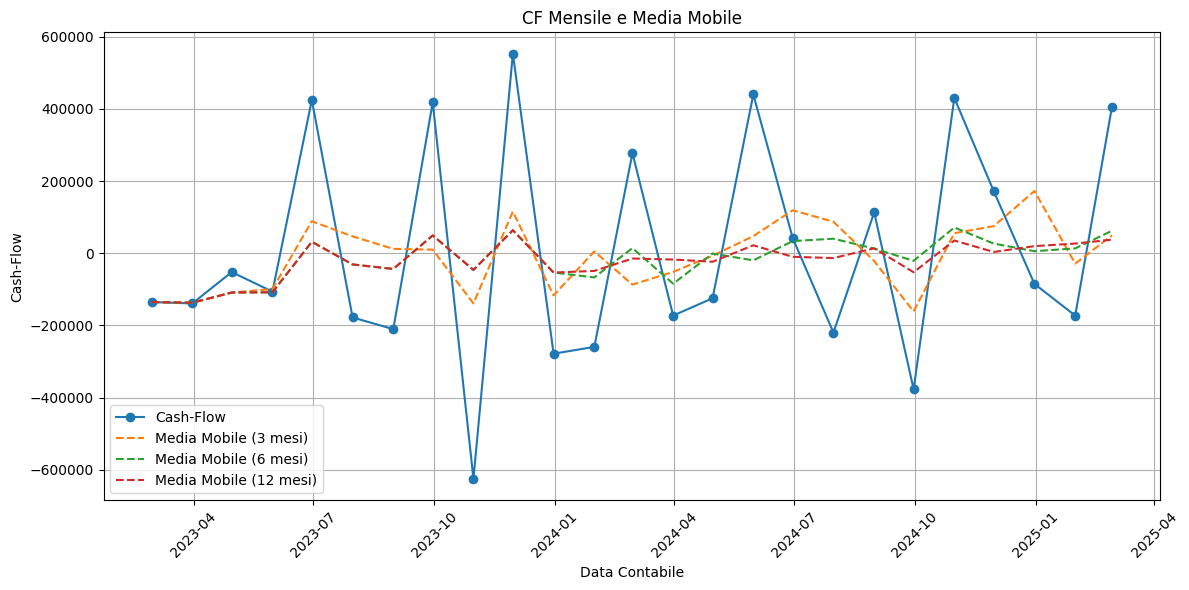

Il periodo più lungo con uscite maggiori delle entrate è stato dal 2023-02-28 al 2023-06-30 (122 giorni).
Il valore di uscita giornaliera più basso è stato di -625454.3600000001€ il giorno 2023-10-31.
Il periodo più lungo con entrate maggiori delle uscite è stato dal 2024-05-31 al 2024-07-31 (61 giorni).
Il valore di entrata giornaliera più alto è stato di 553450.7899999999€ il giorno 2023-11-30.


In [5]:
#Misura del Cash-Flow
from datetime import timedelta

DB_CF = DB.groupby(pd.Grouper(key='data_contabile', freq="ME"))['Importo'].sum().reset_index()
DB_CF['Rolling_Mean_2'] = DB_CF['Importo'].rolling(window=2).mean()
DB_CF['Rolling_Mean_3'] = DB_CF['Importo'].rolling(window=3).mean()
DB_CF['Rolling_Mean_4'] = DB_CF['Importo'].rolling(window=4).mean()
DB_CF['Rolling_Mean_6'] = DB_CF['Importo'].rolling(window=6).mean()
DB_CF['Rolling_Mean_12'] = DB_CF['Importo'].rolling(window=12).mean()
DB_CF['Rolling_Mean_2'] = DB_CF['Rolling_Mean_2'].fillna(DB_CF['Importo'])
DB_CF['Rolling_Mean_3'] = DB_CF['Rolling_Mean_3'].fillna(DB_CF['Rolling_Mean_2'])
DB_CF['Rolling_Mean_4'] = DB_CF['Rolling_Mean_4'].fillna(DB_CF['Rolling_Mean_3'])
DB_CF['Rolling_Mean_6'] = DB_CF['Rolling_Mean_6'].fillna(DB_CF['Rolling_Mean_4'])
DB_CF['Rolling_Mean_12'] = DB_CF['Rolling_Mean_12'].fillna(DB_CF['Rolling_Mean_6'])

plt.figure(figsize=(12, 6))
plt.plot(DB_CF['data_contabile'], DB_CF['Importo'], label='Cash-Flow', marker='o' )
#plt.plot(DB_CF['data_contabile'], DB_CF['Rolling_Mean_2'], label='Media Mobile (2 mesi)', linestyle='--')
plt.plot(DB_CF['data_contabile'], DB_CF['Rolling_Mean_3'], label='Media Mobile (3 mesi)', linestyle='--')
#plt.plot(DB_CF['data_contabile'], DB_CF['Rolling_Mean_4'], label='Media Mobile (4 mesi)', linestyle='--')
plt.plot(DB_CF['data_contabile'], DB_CF['Rolling_Mean_6'], label='Media Mobile (6 mesi)', linestyle='--')
plt.plot(DB_CF['data_contabile'], DB_CF['Rolling_Mean_12'], label='Media Mobile (12 mesi)', linestyle='--')

plt.xlabel('Data Contabile')
plt.ylabel('Cash-Flow')
plt.title('CF Mensile e Media Mobile')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Definisco una soglia per il commento sul cash flow
positive_cf_threshold = 1000
negative_cf_threshold = -1000

# Funzione per identificare i periodi significativi del cash flow
def analyze_expenses(df):
    start_date = None
    expense_greater = False
    longest_period = timedelta(days=0)
    longest_period_start = None
    longest_period_end = None

    for i in range(len(df)):
        date = df.loc[i, 'data_contabile']
        cf_value = df.loc[i, 'Importo']

        if cf_value < 0 and not expense_greater:
            start_date = date
            expense_greater = True
        elif cf_value >= 0 and expense_greater:
            end_date = date
            current_period = end_date - start_date
            if current_period > longest_period:
                longest_period = current_period
                longest_period_start = start_date
                longest_period_end = end_date
            expense_greater = False
            start_date = None

    # Confronto tra i periodi
    if expense_greater:
        end_date = df['data_contabile'].max()
        current_period = end_date - start_date
        if current_period > longest_period:
            longest_period = current_period
            longest_period_start = start_date
            longest_period_end = end_date

    if longest_period_start and longest_period_end:
        comment = f"Il periodo più lungo con uscite maggiori delle entrate è stato dal {longest_period_start.strftime('%Y-%m-%d')} al {longest_period_end.strftime('%Y-%m-%d')} ({longest_period.days} giorni)."
        print(comment)

    # Minimo CF con data
    min_cf_value = df['Importo'].min()
    min_cf_date = df.loc[df['Importo'] == min_cf_value, 'data_contabile'].iloc[0]
    print(f"Il valore di uscita giornaliera più basso è stato di {min_cf_value}€ il giorno {min_cf_date.strftime('%Y-%m-%d')}.")



# Funzione per CF positivo
def analyze_income(df):
    start_date = None
    income_greater = False
    longest_period = timedelta(days=0)
    longest_period_start = None
    longest_period_end = None

    for i in range(len(df)):
        date = df.loc[i, 'data_contabile']
        cf_value = df.loc[i, 'Importo']

        if cf_value > 0 and not income_greater:
            start_date = date
            income_greater = True
        elif cf_value <= 0 and income_greater:
            end_date = date
            current_period = end_date - start_date
            if current_period > longest_period:
                longest_period = current_period
                longest_period_start = start_date
                longest_period_end = end_date
            income_greater = False
            start_date = None

    # Confronto tra i periodi
    if income_greater:
        end_date = df['data_contabile'].max()
        current_period = end_date - start_date
        if current_period > longest_period:
            longest_period = current_period
            longest_period_start = start_date
            longest_period_end = end_date

    if longest_period_start and longest_period_end:
        comment = f"Il periodo più lungo con entrate maggiori delle uscite è stato dal {longest_period_start.strftime('%Y-%m-%d')} al {longest_period_end.strftime('%Y-%m-%d')} ({longest_period.days} giorni)."
        print(comment)

    # Massimo CF
    max_cf_value = df['Importo'].max()
    max_cf_date = df.loc[df['Importo'] == max_cf_value, 'data_contabile'].iloc[0]
    print(f"Il valore di entrata giornaliera più alto è stato di {max_cf_value}€ il giorno {max_cf_date.strftime('%Y-%m-%d')}.")



# Analisi
analyze_expenses(DB_CF)
analyze_income(DB_CF)

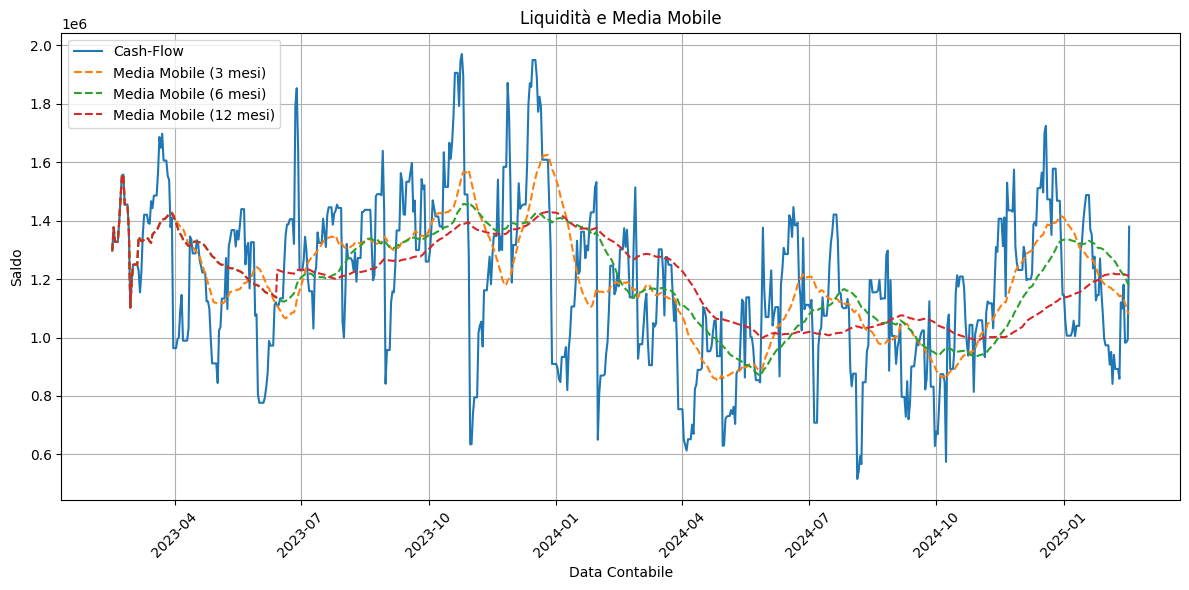


## Spiegazione del Test di Dickey-Fuller e della Stazionarietà ##

Il test di Dickey-Fuller è un test statistico utilizzato per verificare se una serie temporale è stazionaria.
Una serie temporale si dice **stazionaria** se le sue proprietà statistiche (media, varianza, autocorrelazione) rimangono costanti nel tempo.
La stazionarietà è un'assunzione importante per molti modelli di serie temporali, in quanto semplifica la previsione.

Perché misuriamo il p-value?
Il p-value è una misura della probabilità di osservare i dati se l'ipotesi nulla fosse vera. Nel caso del test di Dickey-Fuller,
l'ipotesi nulla è che la serie temporale NON sia stazionaria.
Un p-value basso (tipicamente inferiore a 0.05) indica che possiamo rifiutare l'ipotesi nulla e concludere che la serie temporale è stazionaria.

**Cosa significa stazionario e non stazionario?**
- Stazionario: Le proprietà statistiche della serie temporale sono costanti nel tempo. Questo rende la serie più prevedibile.
- Non stazionario: 

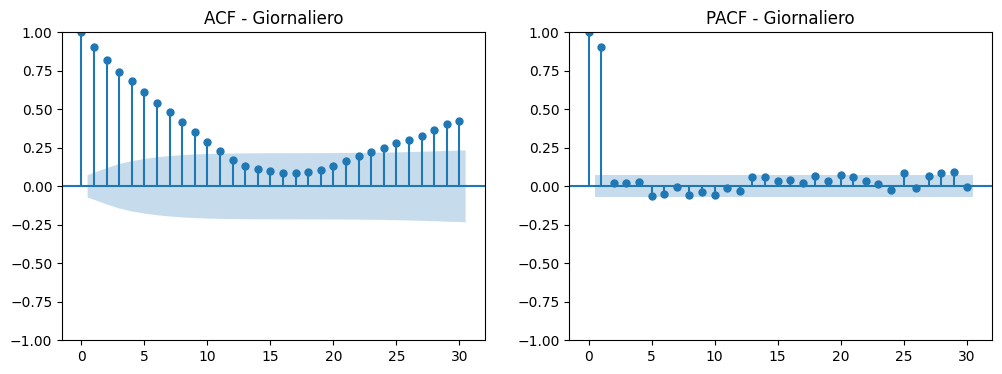


Test di Dickey-Fuller per Settimanale:
Statistica ADF: -1.8768673738610477
P-value: 0.343020441551678
Non stazionario


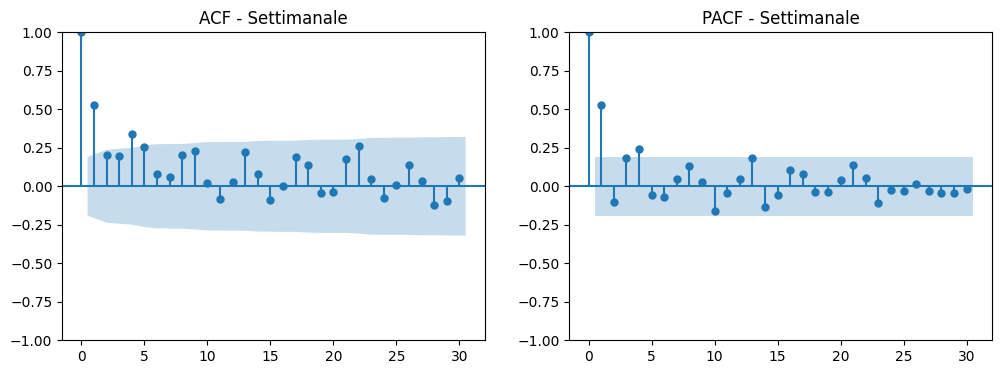


Test di Dickey-Fuller per Mensile:
Statistica ADF: -3.834656409189066
P-value: 0.002571985895968675
Conclusione: Stazionario


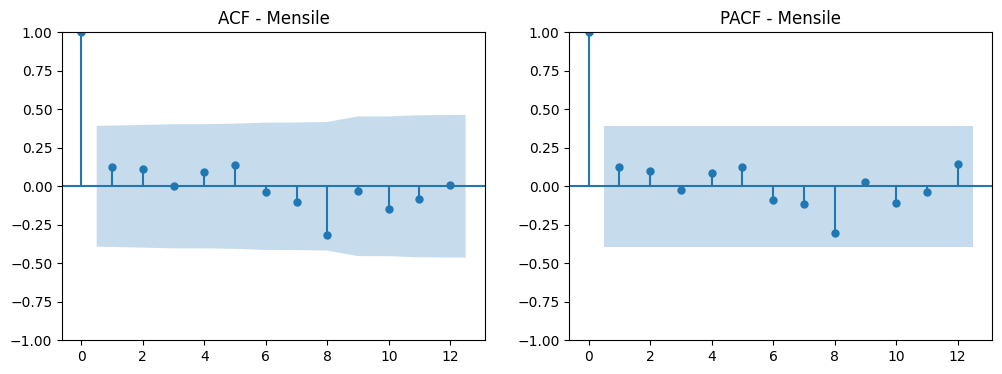

In [6]:
#Misura del Cash-Flow + Saldo (Liquidità)
#Aggiungo i valori mancanti alla serie temporale
DB_Completo = DB[['Importo', 'data_contabile']].copy()
DB_Completo['data_contabile'] = pd.to_datetime(DB_Completo['data_contabile'])
DB_Completo = DB_Completo.groupby('data_contabile')['Importo'].sum().reset_index()
DB_Completo.loc[0, 'Importo'] += saldo_iniziale
date_range = pd.date_range(start=DB_Completo['data_contabile'].min(), end=DB_Completo['data_contabile'].max(), freq='D')
DB_Completo = DB_Completo.set_index('data_contabile').reindex(date_range)
DB_Completo['Importo'] = DB_Completo['Importo'].fillna(0)
DB_Completo.reset_index(inplace=True)
DB_Completo = DB_Completo.rename(columns={'index': 'data_contabile'})

#Calcolo la Somma Cumulata degli spostamenti aggiungendo il Saldo Iniziale
DB_Completo = DB_Completo.reset_index()
DB_daily_sum = DB_Completo.groupby('data_contabile')['Importo'].sum().reset_index()
DB_daily_sum = DB_daily_sum.rename(columns={'Importo': 'Importo_cumulato'})
DB_CFC = DB_daily_sum.copy()
DB_CFC['Importo_cumulato'] = DB_CFC['Importo_cumulato'].cumsum()


DB_CFC['Rolling_Mean_2'] = DB_CFC['Importo_cumulato'].rolling(window=20).mean()
DB_CFC['Rolling_Mean_3'] = DB_CFC['Importo_cumulato'].rolling(window=30).mean()
DB_CFC['Rolling_Mean_4'] = DB_CFC['Importo_cumulato'].rolling(window=40).mean()
DB_CFC['Rolling_Mean_6'] = DB_CFC['Importo_cumulato'].rolling(window=60).mean()
DB_CFC['Rolling_Mean_12'] = DB_CFC['Importo_cumulato'].rolling(window=120).mean()
DB_CFC['Rolling_Mean_2'] = DB_CFC['Rolling_Mean_2'].fillna(DB_CFC['Importo_cumulato'])
DB_CFC['Rolling_Mean_3'] = DB_CFC['Rolling_Mean_3'].fillna(DB_CFC['Rolling_Mean_2'])
DB_CFC['Rolling_Mean_4'] = DB_CFC['Rolling_Mean_4'].fillna(DB_CFC['Rolling_Mean_3'])
DB_CFC['Rolling_Mean_6'] = DB_CFC['Rolling_Mean_6'].fillna(DB_CFC['Rolling_Mean_4'])
DB_CFC['Rolling_Mean_12'] = DB_CFC['Rolling_Mean_12'].fillna(DB_CFC['Rolling_Mean_6'])

plt.figure(figsize=(12, 6))
plt.plot(DB_CFC['data_contabile'], DB_CFC['Importo_cumulato'], label='Cash-Flow', linestyle='-')
#plt.plot(DB_CFC['data_contabile'], DB_CFC['Rolling_Mean_2'], label='Media Mobile (2 mesi)', linestyle='--')
plt.plot(DB_CFC['data_contabile'], DB_CFC['Rolling_Mean_3'], label='Media Mobile (3 mesi)', linestyle='--')
#plt.plot(DB_CFC['data_contabile'], DB_CFC['Rolling_Mean_4'], label='Media Mobile (4 mesi)', linestyle='--')
plt.plot(DB_CFC['data_contabile'], DB_CFC['Rolling_Mean_6'], label='Media Mobile (6 mesi)', linestyle='--')
plt.plot(DB_CFC['data_contabile'], DB_CFC['Rolling_Mean_12'], label='Media Mobile (12 mesi)', linestyle='--')

plt.xlabel('Data Contabile')
plt.ylabel('Saldo')
plt.title('Liquidità e Media Mobile')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Prima della misurazione della stazionarità, spiegazione del test di Dickey-Fuller
print("\n## Spiegazione del Test di Dickey-Fuller e della Stazionarietà ##")
print("\nIl test di Dickey-Fuller è un test statistico utilizzato per verificare se una serie temporale è stazionaria.")
print("Una serie temporale si dice **stazionaria** se le sue proprietà statistiche (media, varianza, autocorrelazione) rimangono costanti nel tempo.")
print("La stazionarietà è un'assunzione importante per molti modelli di serie temporali, in quanto semplifica la previsione.")

print("\nPerché misuriamo il p-value?")
print("Il p-value è una misura della probabilità di osservare i dati se l'ipotesi nulla fosse vera. Nel caso del test di Dickey-Fuller,")
print("l'ipotesi nulla è che la serie temporale NON sia stazionaria.")
print("Un p-value basso (tipicamente inferiore a 0.05) indica che possiamo rifiutare l'ipotesi nulla e concludere che la serie temporale è stazionaria.")

print("\n**Cosa significa stazionario e non stazionario?**")
print("- Stazionario: Le proprietà statistiche della serie temporale sono costanti nel tempo. Questo rende la serie più prevedibile.")
print("- Non stazionario: Le proprietà statistiche della serie temporale cambiano nel tempo. Questo rende la serie più difficile da prevedere.")

print("\nIn questo caso, l'aggiunta del saldo iniziale rende la serie temporale stazionaria, in quanto introduce un livello di base costante.")
print("Ciò semplificherebbe la previsione del cash flow, poiché i modelli di serie temporali possono sfruttare questa stabilità.")


# Caricamento del dataset
DB_Completo = DB_CFC.copy()

# Aggregazione a diversi livelli
df_daily = DB_Completo.groupby('data_contabile')['Importo_cumulato'].sum()
df_weekly = df_daily.resample('W').sum()
df_monthly = df_daily.resample('ME').sum()

# Funzione per test di Dickey-Fuller
def adf_test(series, title):
    result = adfuller(series.dropna())
    print(f'\nTest di Dickey-Fuller per {title}:')
    print(f'Statistica ADF: {result[0]}')
    print(f'P-value: {result[1]}')
    print('Conclusione: Stazionario' if result[1] < 0.05 else 'Non stazionario')

# Funzione per plottare ACF e PACF con lag limitati
def plot_acf_pacf(series, title):
    lags = min(30, len(series) // 2)  # Numero di lag massimo = metà delle osservazioni disponibili
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    sm.graphics.tsa.plot_acf(series.dropna(), lags=lags, ax=axes[0])
    sm.graphics.tsa.plot_pacf(series.dropna(), lags=lags, ax=axes[1])
    axes[0].set_title(f'ACF - {title}')
    axes[1].set_title(f'PACF - {title}')
    plt.show()

# Analisi per ogni livello
timeseries = {'Giornaliero': df_daily, 'Settimanale': df_weekly, 'Mensile': df_monthly}
for key, series in timeseries.items():
    adf_test(series, key)
    plot_acf_pacf(series, key)


In [7]:
Aziende_Cluster = [57,67,71,74,299,342,2630,378]
DB = database[['data_contabile', 'Importo', 'Azienda','Id_conto']]
DB['Id_conto'] = DB['Id_conto'].astype(int)
train_data_list = []
test_data_list = []

for y in Aziende_Cluster:
    DB_Cluster = database[database['Azienda'] == y]
    daily_sum = DB_Cluster.groupby('data_contabile')['Importo'].sum().reset_index()

    # Sommo i movimenti nei singoli giorni e riempio i giorni mancanti con Importo = 0
    min_date = daily_sum['data_contabile'].min()
    max_date = daily_sum['data_contabile'].max()
    all_dates = pd.date_range(start=min_date, end=max_date, freq='D')
    all_dates_df = pd.DataFrame({'data_contabile': all_dates, 'Importo': 0})
    daily_sum = pd.merge(all_dates_df, daily_sum, on='data_contabile', how='left')
    daily_sum['Importo'] = daily_sum['Importo_y'].fillna(daily_sum['Importo_x'])
    daily_sum = daily_sum[['data_contabile', 'Importo']]
    daily_sum['Id_Azienda'] = y

    #Sommo il Saldo Iniziale dei conti delle aziende al primo giorno
    Saldo_Conto = saldo_iniziale_df.merge(DB_Cluster['Id_conto'].value_counts(), on='Id_conto', how='left')
    Saldo_Conto.dropna(inplace=True)
    saldo_iniziale = Saldo_Conto['saldo'].sum()
    daily_sum.loc[0, 'Importo'] += saldo_iniziale

    # Calcolo la Liquidità
    daily_sum['Liquidità'] = daily_sum['Importo'].cumsum()

    # Suddivisione in Train (tutti i dati tranne gli ultimi 6 mesi) e Test (ultimi 6 mesi)
    train_size = len(daily_sum) - 180
    train_data = daily_sum.iloc[:train_size]  # Train set
    test_data = daily_sum.iloc[train_size:]   # Test set

    # Aggiungi i dati di train e test alle liste
    train_data_list.append(train_data)
    test_data_list.append(test_data)

# Concatena tutti i DataFrame di train e test in un unico DataFrame
train_data_TOT = pd.concat(train_data_list, ignore_index=True)
test_data_TOT = pd.concat(test_data_list, ignore_index=True)

# Creo Features Temporali
test_data_TOT['Giorno'] = test_data_TOT['data_contabile'].dt.day
test_data_TOT['Mese'] = test_data_TOT['data_contabile'].dt.month
test_data_TOT['Trimestre'] = test_data_TOT['data_contabile'].dt.quarter
test_data_TOT['Semestre'] = (test_data_TOT['data_contabile'].dt.month - 1) // 6 + 1
test_data_TOT['Anno'] = test_data_TOT['data_contabile'].dt.year

train_data_TOT['Giorno'] = train_data_TOT['data_contabile'].dt.day
train_data_TOT['Mese'] = train_data_TOT['data_contabile'].dt.month
train_data_TOT['Trimestre'] = train_data_TOT['data_contabile'].dt.quarter
train_data_TOT['Semestre'] = (train_data_TOT['data_contabile'].dt.month - 1) // 6 + 1
train_data_TOT['Anno'] = train_data_TOT['data_contabile'].dt.year

train_data_TOT = pd.get_dummies(train_data_TOT, columns=['Id_Azienda'], prefix=['company'])
test_data_TOT = pd.get_dummies(test_data_TOT, columns=['Id_Azienda'], prefix=['company'])

train_data_TOT = train_data_TOT.rename(columns={'data_contabile': 'ds', 'Liquidità': 'y'})
test_data_TOT = test_data_TOT.rename(columns={'data_contabile': 'ds', 'Liquidità': 'y'})

test_data_TOT = test_data_TOT.sort_values(by=['ds'])
train_data_TOT = train_data_TOT.sort_values(by=['ds'])
Train_data_TOT = train_data_TOT.copy()

# Divido il Validation Set dal Train Set (60 giorni)
validation_size = 180
max_train_date = train_data_TOT['ds'].max()
validation_start_date = max_train_date - pd.DateOffset(days=validation_size -1)
validation_data_TOT = train_data_TOT[(train_data_TOT['ds'] >= validation_start_date) & (train_data_TOT['ds'] <= max_train_date)]
train_data_TOT = train_data_TOT[train_data_TOT['ds'] < validation_start_date]

print("Train Set Shape:", train_data_TOT.shape)
print("Validation Set Shape:", validation_data_TOT.shape)
print("Test Set Shape:", test_data_TOT.shape)

/var/tmp/ipykernel_6340/127901546.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DB['Id_conto'] = DB['Id_conto'].astype(int)


Train Set Shape: (2989, 16)
Validation Set Shape: (1440, 16)
Test Set Shape: (1440, 16)


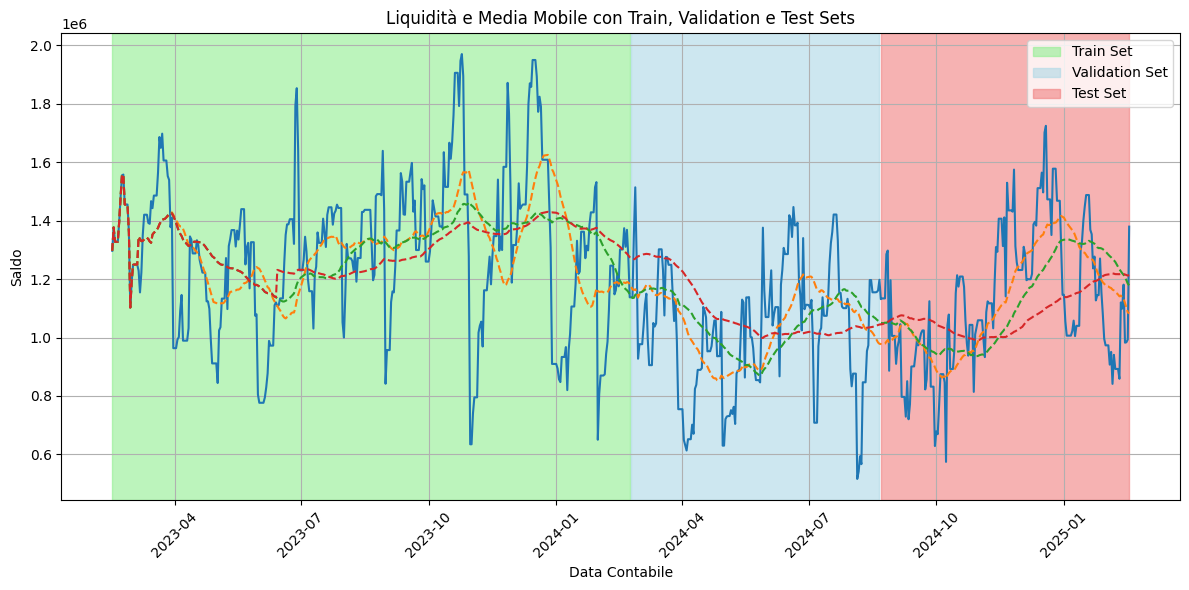

In [8]:
# Rappresentazione grafica delle dimensioni del Test, Train e Validation Sets

# Definisco le dimensioni dei Sets
train_size = len(DB_CFC) - 180 - 180  # Total data points - test set size - validation set size
validation_size = 180  # Validation set size
test_size = 180  # Test set size

# Divido i dati in train, validation, and test sets
train_data = DB_CFC.iloc[:train_size]
validation_data = DB_CFC.iloc[train_size : train_size + validation_size]
test_data = DB_CFC.iloc[train_size + validation_size:]

#Ordino i dataset in base al tempo
train_data = train_data.sort_values(by=['data_contabile'])
validation_data = validation_data.sort_values(by=['data_contabile'])
test_data = test_data.sort_values(by=['data_contabile'])


# Grafico train, validation, e test sets
plt.figure(figsize=(12, 6))
plt.plot(DB_CFC['data_contabile'], DB_CFC['Importo_cumulato'], linestyle='-')
plt.plot(DB_CFC['data_contabile'], DB_CFC['Rolling_Mean_3'], linestyle='--')
plt.plot(DB_CFC['data_contabile'], DB_CFC['Rolling_Mean_6'], linestyle='--')
plt.plot(DB_CFC['data_contabile'], DB_CFC['Rolling_Mean_12'], linestyle='--')
plt.axvspan(train_data_TOT['ds'].min(), train_data_TOT['ds'].max(), color='lightgreen', alpha=0.6, label='Train Set')
plt.axvspan(validation_data_TOT['ds'].min(), validation_data_TOT['ds'].max(), color='lightblue', alpha=0.6, label='Validation Set')
plt.axvspan(test_data_TOT['ds'].min(), test_data_TOT['ds'].max(), color='lightcoral', alpha=0.6, label='Test Set')
plt.xlabel('Data Contabile')
plt.ylabel('Saldo')
plt.title('Liquidità e Media Mobile con Train, Validation e Test Sets')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np
import itertools

# Tempo di attesa: 5 minuti.
# Utilizzo Paramid Grid per scegliere il modello dagli iperparametri migliori
# Due ordini di Fourier sono stati semplicificati per velocità di calcolo, ma essi rappresentano comunque valori ottimali
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_mode': ['additive', 'multiplicative'],
    'fourier_order_weekly': [3],
    'fourier_order_monthly': [5],
    'fourier_order_yearly': [10, 15, 20],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]
}

# Genera tutte le combinazioni di parametri
company_cols = [col for col in train_data_TOT.columns if col.startswith('company_')]
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
best_rmse = float("inf")
best_mape = float("inf")
best_train_forecast = None
best_test_forecast = None
best_model = None

# Grid search loop
for params in all_params:
    model = Prophet(
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_mode=params['seasonality_mode'],
        seasonality_prior_scale=params['seasonality_prior_scale']
    )

    # Componenti stagioali con specifici ordini di Fourier
    model.add_seasonality(name='weekly', period=7, fourier_order=params['fourier_order_weekly'])
    model.add_seasonality(name='monthly', period=30.5, fourier_order=params['fourier_order_monthly'])
    model.add_seasonality(name='yearly', period=365.25, fourier_order=params['fourier_order_yearly'])

    # Regressori
    for company_id in Aziende_Cluster:
        model.add_regressor(f'company_{company_id}')
    model.add_regressor('Importo')
    model.add_regressor('Giorno')
    model.add_regressor('Mese')
    model.add_regressor('Trimestre')
    model.add_regressor('Semestre')
    model.add_regressor('Anno')

    model.fit(train_data_TOT)
    validation_forecast = model.predict(validation_data_TOT)

    #Calcolo RMSE e MAPE
    rmse = np.sqrt(mean_squared_error(validation_data_TOT['y'], validation_forecast['yhat']))
    mape = mean_absolute_percentage_error(validation_data_TOT['y'], validation_forecast['yhat'])

    # Seleziono il modello con l'errore più basso
    if rmse < best_rmse and mape < best_mape:
        best_rmse = rmse
        best_mape = mape
        best_model = model
        best_params = params
        best_train_forecast = model.predict(Train_data_TOT)
        best_test_forecast = model.predict(test_data_TOT)

print(f"Best parameters: {best_params}")
print(f"Best Validation RMSE: {best_rmse}")
print(f"Best Validation MAPE: {best_mape:.2f}%")

15:44:23 - cmdstanpy - INFO - Chain [1] start processing
15:44:23 - cmdstanpy - INFO - Chain [1] done processing
15:44:25 - cmdstanpy - INFO - Chain [1] start processing
15:44:25 - cmdstanpy - INFO - Chain [1] done processing
15:44:26 - cmdstanpy - INFO - Chain [1] start processing
15:44:26 - cmdstanpy - INFO - Chain [1] done processing
15:44:27 - cmdstanpy - INFO - Chain [1] start processing
15:44:27 - cmdstanpy - INFO - Chain [1] done processing
15:44:28 - cmdstanpy - INFO - Chain [1] start processing
15:44:28 - cmdstanpy - INFO - Chain [1] done processing
15:44:29 - cmdstanpy - INFO - Chain [1] start processing
15:44:29 - cmdstanpy - INFO - Chain [1] done processing
15:44:30 - cmdstanpy - INFO - Chain [1] start processing
15:44:30 - cmdstanpy - INFO - Chain [1] done processing
15:44:31 - cmdstanpy - INFO - Chain [1] start processing
15:44:31 - cmdstanpy - INFO - Chain [1] done processing
15:44:32 - cmdstanpy - INFO - Chain [1] start processing
15:44:33 - cmdstanpy - INFO - Chain [1]

Best parameters: {'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'fourier_order_weekly': 3, 'fourier_order_monthly': 5, 'fourier_order_yearly': 10, 'seasonality_prior_scale': 0.01}
Best Validation RMSE: 616036.595117042
Best Validation MAPE: 3.81%


In [10]:
# Unire Train_data_TOT e best_train_forecast, valori reali e quelli predetti, per calcolare le differeze
# Identifica tutte le colonne che iniziano con "company_"
company_cols = [col for col in Train_data_TOT.columns if col.startswith("company_")]

# Lista per salvare i DataFrame filtrati e modificati
df_list = []

# Itera su ogni company
for company in company_cols:
    # Filtra i dati per la company corrente
    Train_data_filtered = Train_data_TOT[Train_data_TOT[company] != 0].copy()
    best_train_filtered = best_train_forecast[best_train_forecast[company] != 0].copy()

    # Evita errori di allineamento degli indici
    best_train_filtered = best_train_filtered.set_index("ds")
    Train_data_filtered = Train_data_filtered.set_index("ds")

    # Calcola la differenza tra y e yhat
    Train_data_filtered["Residui"] = Train_data_filtered["y"] - best_train_filtered["yhat"]

    # Riporta l'indice ds come colonna normale
    Train_data_filtered.reset_index(inplace=True)

    # Aggiunge il DataFrame processato alla lista
    df_list.append(Train_data_filtered)

# Concatena tutti i DataFrame in uno solo
Train_data_TOT_final = pd.concat(df_list, ignore_index=True)

In [11]:
# Unisco test_data_TOT e best_test_forecast, valori reali e predetti, per calcolare le differeze
# Identifica tutte le colonne che iniziano con "company_"
company_cols = [col for col in test_data_TOT.columns if col.startswith("company_")]

# Lista per salvare i DataFrame filtrati e modificati
df_list = []

# Itera su ogni company
for company in company_cols:
    # Filtra i dati per la company corrente
    test_data_filtered = test_data_TOT[test_data_TOT[company] != 0].copy()
    best_test_filtered = best_test_forecast[best_test_forecast[company] != 0].copy()

    # Evita errori di allineamento degli indici
    best_test_filtered = best_test_filtered.set_index("ds")
    test_data_filtered = test_data_filtered.set_index("ds")

    # Calcola la differenza tra y e yhat
    test_data_filtered["Residui"] = test_data_filtered["y"] - best_test_filtered["yhat"]

    # Riporta l'indice ds come colonna normale
    test_data_filtered.reset_index(inplace=True)

    # Aggiunge il DataFrame processato alla lista
    df_list.append(test_data_filtered)

# Concatena tutti i DataFrame in uno solo
test_data_TOT_final = pd.concat(df_list, ignore_index=True)

In [12]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np
import pandas as pd

# 🔹 1. Riaddestriamo il modello migliore su Train + Validation (aggiungendo i residui)
final_model = Prophet(
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_mode=best_params['seasonality_mode'],
    seasonality_prior_scale=best_params['seasonality_prior_scale']
)

# Aggiunta stagionalità con i migliori iperparametri
final_model.add_seasonality(name='weekly', period=7, fourier_order=best_params['fourier_order_weekly'])
final_model.add_seasonality(name='monthly', period=30.5, fourier_order=best_params['fourier_order_monthly'])
final_model.add_seasonality(name='yearly', period=365.25, fourier_order=best_params['fourier_order_yearly'])

# Aggiunta regressori standard
for company_id in Aziende_Cluster:
    final_model.add_regressor(f'company_{company_id}')
final_model.add_regressor('Importo')
final_model.add_regressor('Giorno')
final_model.add_regressor('Mese')
final_model.add_regressor('Trimestre')
final_model.add_regressor('Semestre')
final_model.add_regressor('Anno')

# Aggiungiamo il regressore "Residui"
final_model.add_regressor('Residui')

# 🔹 2. Fit del modello su Train + Validation
final_model.fit(Train_data_TOT_final)

# 🔹 3. Previsione sul Test Set
final_test_forecast = final_model.predict(test_data_TOT_final)

# 🔹 4. Calcolo metriche di errore sul Test Set
final_rmse = np.sqrt(mean_squared_error(test_data_TOT_final['y'], final_test_forecast['yhat']))
final_mape = mean_absolute_percentage_error(test_data_TOT_final['y'], final_test_forecast['yhat'])

print(f"Final RMSE sul Test Set delle 8 Aziende: {final_rmse}")
print(f"Final MAPE sul Test Set delle 8 Aziende: {final_mape:.2f}%")


15:48:00 - cmdstanpy - INFO - Chain [1] start processing
15:48:11 - cmdstanpy - INFO - Chain [1] done processing


Final RMSE sul Test Set delle 8 Aziende: 1662048.297126916
Final MAPE sul Test Set delle 8 Aziende: 14.45%


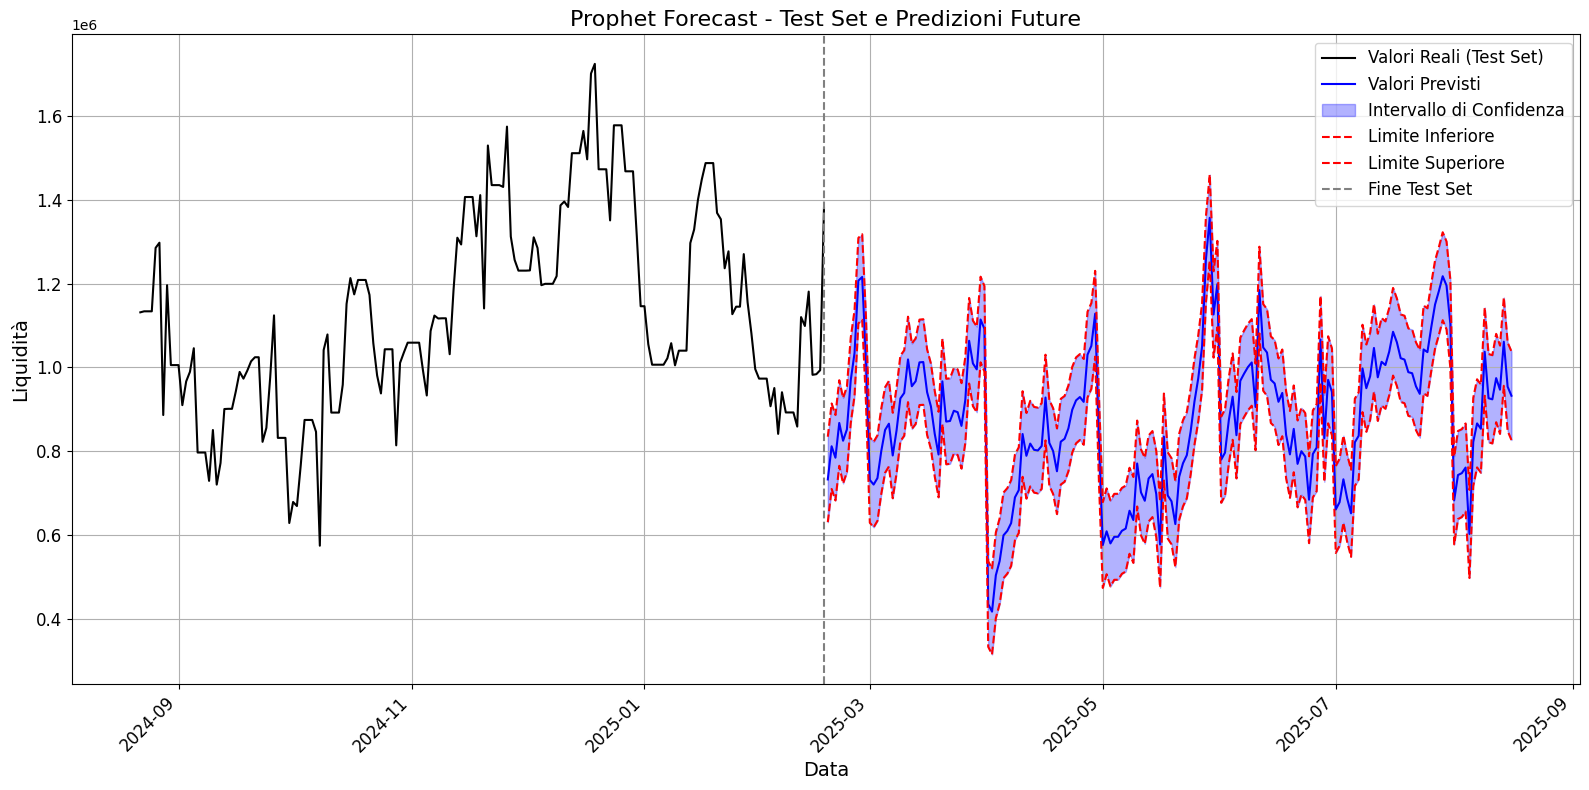

In [13]:
# Estraggo i dati dell'azienda selezionata
Train_data_TOT_x = Train_data_TOT_final[Train_data_TOT_final[f'company_{x}'] != 0].copy()
test_data_TOT_x = test_data_TOT_final[test_data_TOT_final[f'company_{x}'] != 0].copy()
test_data_TOT_x['y'] = DB_CFC[DB_CFC['data_contabile'].isin(test_data_TOT_x['ds'])]['Importo_cumulato'].values

# 1. Crea un DataFrame con le date future (6 mesi) partendo dal giorno dopo l'ultimo giorno del Test Set
last_test_date = test_data_TOT_final['ds'].max()  # Ottieni l'ultimo giorno del Test Set
future_dates = pd.DataFrame({'ds': pd.date_range(start=last_test_date + pd.Timedelta(days=1), periods=180, freq='D')})  # Crea DataFrame con date future

# 2. Calcola giorno, mese, trimestre, semestre e anno per le date future
future_dates['Giorno'] = future_dates['ds'].dt.day
future_dates['Mese'] = future_dates['ds'].dt.month
future_dates['Trimestre'] = future_dates['ds'].dt.quarter
future_dates['Semestre'] = (future_dates['ds'].dt.month - 1) // 6 + 1
future_dates['Anno'] = future_dates['ds'].dt.year

# 3. Ottieni gli importi dell'anno precedente per le date corrispondenti
previous_year_data = Train_data_TOT_x[Train_data_TOT_x['ds'].dt.year == future_dates['ds'].dt.year[0] - 1]
previous_year_amounts = {}
for index, row in previous_year_data.iterrows():
    month = row['ds'].month
    day = row['ds'].day
    previous_year_amounts[(month, day)] = row['Importo']
future_dates['Importo'] = future_dates.apply(lambda row: previous_year_amounts.get((row['Mese'], row['Giorno']), 0), axis=1) 

# Predico i  'Residui' con un mini regressore lineare ***
from sklearn.linear_model import LinearRegression
reg_residui = LinearRegression()
X_train = Train_data_TOT_x[['Giorno', 'Mese', 'Trimestre', 'Semestre', 'Anno']]  
y_train_residui = Train_data_TOT_x['Residui']
reg_residui.fit(X_train, y_train_residui)
X_future = future_dates[['Giorno', 'Mese', 'Trimestre', 'Semestre', 'Anno']]
future_dates['Residui'] = reg_residui.predict(X_future)

# Aggiungo le colonne 'company'
for company_id in Aziende_Cluster:
    future_dates[f'company_{company_id}'] = 0
future_dates[f'company_{x}'] = 1  

# Predizioni con il modello Prophet
forecast_future = final_model.predict(future_dates)

# Controllo se le predizioni partono dall'ultimo valore reale
last_actual_value = test_data_TOT_x['y'].iloc[-1]  # Last actual value
first_predicted_value = forecast_future['yhat'].iloc[0]  # First predicted value
difference = last_actual_value - first_predicted_value
threshold = 1000000  
if abs(difference) > threshold:
    forecast_future['yhat'] = forecast_future['yhat'] + difference
    forecast_future['yhat_lower'] = forecast_future['yhat_lower'] + difference
    forecast_future['yhat_upper'] = forecast_future['yhat_upper'] + difference
    
# Grafico
plt.figure(figsize=(16, 8))
plt.plot(test_data_TOT_x['ds'], test_data_TOT_x['y'], color='black', label='Valori Reali (Test Set)')
plt.plot(forecast_future['ds'], forecast_future['yhat'], color='blue', label='Valori Previsti')
plt.fill_between(forecast_future['ds'], forecast_future['yhat_lower'] - 100000, forecast_future['yhat_upper'] + 100000,
                 color='blue', alpha=0.3, label='Intervallo di Confidenza')
plt.plot(forecast_future['ds'], forecast_future['yhat_lower'] - 100000, color='red', linestyle='--', label='Limite Inferiore')
plt.plot(forecast_future['ds'], forecast_future['yhat_upper'] + 100000, color='red', linestyle='--', label='Limite Superiore')
plt.axvline(x=last_test_date, color='gray', linestyle='--', label='Fine Test Set')
plt.title("Prophet Forecast - Test Set e Predizioni Future", fontsize=16)
plt.xlabel("Data", fontsize=14)
plt.ylabel("Liquidità", fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

Guadagni di Liquidità in 6 mesi: 7425648.571588414
Guadagni di Liquidità What-If: 8168213.428747256


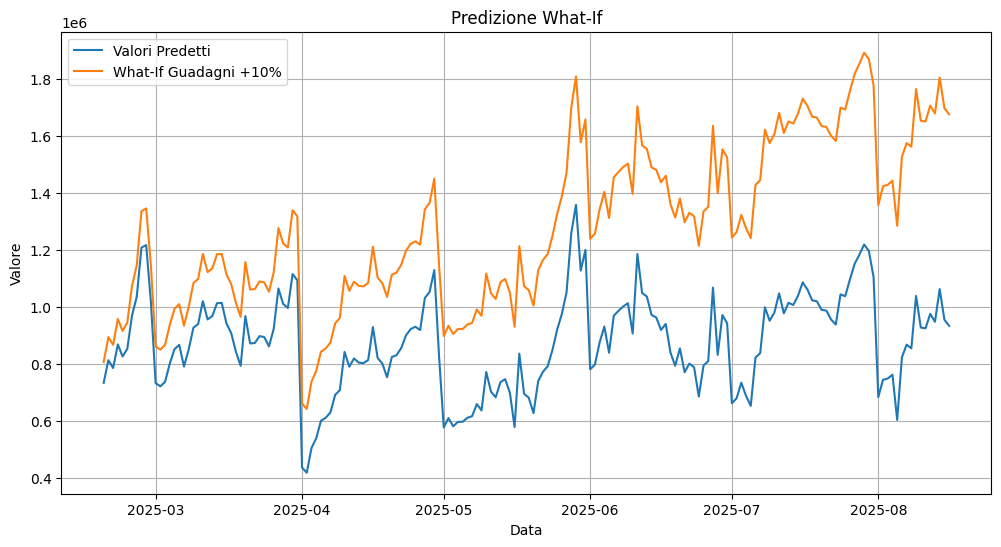

La possibile aumenti dei guadagni di: 742564.86, è data da:

## Incidenza delle Top 5 Entrate e Potenziale Variazione nel What-If ##
L'entrata 'BONIFICO A VS FAVORE' ha una percentuale di incidenza del 67.68%, che porta ad un'entrata possibile di 502574.64€ nel what-if.
L'entrata 'INCASSO TRAMITE P.O.S.' ha una percentuale di incidenza del 10.86%, che porta ad un'entrata possibile di 80660.13€ nel what-if.
L'entrata 'VERSAMENTO CONTANTI/VAL.ASSIM.' ha una percentuale di incidenza del 7.91%, che porta ad un'entrata possibile di 58768.34€ nel what-if.
L'entrata 'VERSAMENTO DI ASSEGNI BANCARI' ha una percentuale di incidenza del 7.17%, che porta ad un'entrata possibile di 53266.12€ nel what-if.
L'entrata 'VERSAMENTO DI ASSEGNI CIRCOLARI EMESSI DA ALTRE BANCHE' ha una percentuale di incidenza del 2.14%, che porta ad un'entrata possibile di 15921.30€ nel what-if.


In [14]:
# What-If
alternative_future_W = forecast_future[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
alternative_future_W['incrementi'] = alternative_future_W['yhat'].diff()
alternative_future_W['incrementi_lower'] = alternative_future_W['yhat_lower'].diff()
alternative_future_W['incrementi_upper'] = alternative_future_W['yhat_upper'].diff()
alternative_future_W['incrementi'] = alternative_future_W['incrementi'].fillna(alternative_future_W['yhat'])
alternative_future_W['incrementi_lower'] = alternative_future_W['incrementi_lower'].fillna(alternative_future_W['yhat_lower'])
alternative_future_W['incrementi_upper'] = alternative_future_W['incrementi_upper'].fillna(alternative_future_W['yhat_upper'])

# Calcolo e stampa dei guadagni totali (incrementi positivi)
sum_positive_increments = alternative_future_W.loc[alternative_future_W['incrementi'] > 0, 'incrementi'].sum()
print(f"Guadagni di Liquidità in 6 mesi: {sum_positive_increments}")

# Crea copie separate per gli scenari what-if
alternative_future_W_guadagni = alternative_future_W.copy()

# Aumento dei guadagni del 10% nello scenario guadagni
alternative_future_W_guadagni.loc[alternative_future_W_guadagni['incrementi'] > 0, 'incrementi'] *= 1.10

# Calcolo della somma cumulativa degli incrementi per entrambi gli scenari
alternative_future_W_guadagni['incrementi_cumulati'] = alternative_future_W_guadagni['incrementi'].cumsum()

sum_positive_increments = alternative_future_W.loc[alternative_future_W['incrementi'] > 0, 'incrementi'].sum()
print(f'Guadagni di Liquidità What-If: {sum_positive_increments*1.1}')

# Plot dei risultati con linee separate per perdite e guadagni
plt.figure(figsize=(12, 6))
plt.plot(alternative_future_W['ds'], alternative_future_W['yhat'], label='Valori Predetti')
plt.plot(alternative_future_W_guadagni['ds'], alternative_future_W_guadagni['incrementi_cumulati'], label='What-If Guadagni +10%')
plt.xlabel('Data')
plt.ylabel('Valore')
plt.title('Predizione What-If')
plt.legend()
plt.grid(True)
plt.show()

print(f'La possibile aumenti dei guadagni di: {(sum_positive_increments*1.1-sum_positive_increments):.2f}, è data da:')

# Calcolo e stampa della percentuale delle 5 entrate più frequenti e la loro variazione nel what-if
total_entrate_frequenza = DB_Entrate_countCausali['Frequenza'].sum()  # Calcola la frequenza totale delle entrate
what_if_difference = sum_positive_increments * 1.1 - sum_positive_increments # Calcola la differenza nel what-if

print("\n## Incidenza delle Top 5 Entrate e Potenziale Variazione nel What-If ##")
for index, row in DB_Entrate_countCausali.head(5).iterrows():
    percentuale_incidenza = (row['Frequenza'] / total_entrate_frequenza) * 100
    variazione_what_if = percentuale_incidenza / 100 * what_if_difference
    print(f"L'entrata '{row['DESCRIZIONE']}' ha una percentuale di incidenza del {percentuale_incidenza:.2f}%, "
          f"che porta ad un'entrata possibile di {variazione_what_if:.2f}€ nel what-if.")

Perdite di Liquidità in 6 mesi: -6493283.30


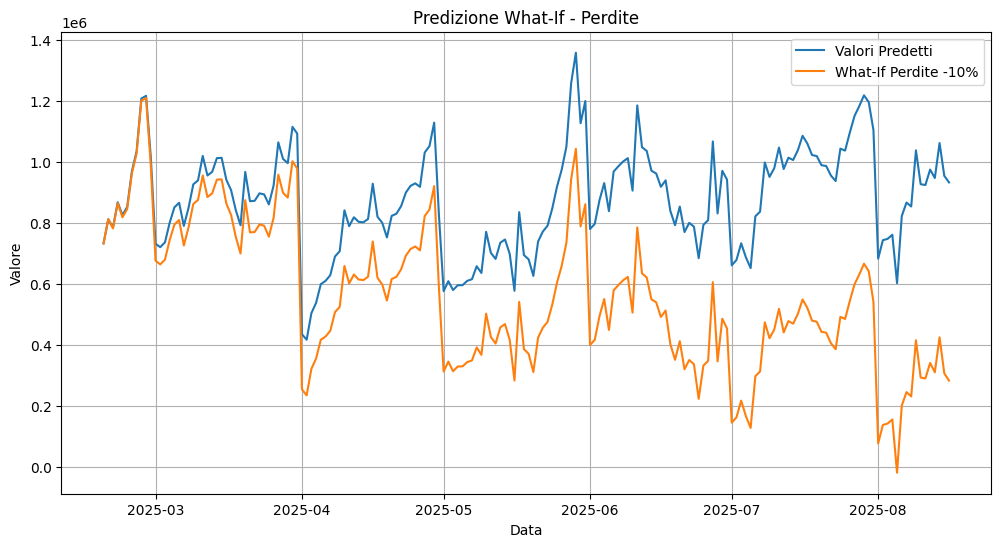


## Incidenza delle Top 5 Uscite e Potenziale Variazione nel What-If ##
L'uscita 'PAGAMENTI DIVERSI' ha una percentuale di incidenza del 33.56%, che porta ad una variazione di 249194.77€ nel what-if.
L'uscita 'COMMISSIONI' ha una percentuale di incidenza del 29.29%, che porta ad una variazione di 217509.49€ nel what-if.
L'uscita 'DISPOSIZIONI DIVERSE' ha una percentuale di incidenza del 18.70%, che porta ad una variazione di 138871.44€ nel what-if.
L'uscita 'EFFETTI RITIRATI' ha una percentuale di incidenza del 9.01%, che porta ad una variazione di 66926.00€ nel what-if.
L'uscita 'IMPOSTE E TASSE' ha una percentuale di incidenza del 3.18%, che porta ad una variazione di 23633.24€ nel what-if.


In [15]:
# What-If
alternative_future_W_perdite = forecast_future[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
alternative_future_W_perdite['incrementi'] = alternative_future_W_perdite['yhat'].diff()
alternative_future_W_perdite['incrementi_lower'] = alternative_future_W_perdite['yhat_lower'].diff()
alternative_future_W_perdite['incrementi_upper'] = alternative_future_W_perdite['yhat_upper'].diff()
alternative_future_W_perdite['incrementi'] = alternative_future_W_perdite['incrementi'].fillna(alternative_future_W_perdite['yhat'])
alternative_future_W_perdite['incrementi_lower'] = alternative_future_W_perdite['incrementi_lower'].fillna(alternative_future_W_perdite['yhat_lower'])
alternative_future_W_perdite['incrementi_upper'] = alternative_future_W_perdite['incrementi_upper'].fillna(alternative_future_W_perdite['yhat_upper'])

# Calcolo e stampa delle perdite totali (incrementi negativi)
sum_negative_increments = alternative_future_W_perdite.loc[alternative_future_W_perdite['incrementi'] < 0, 'incrementi'].sum()
print(f"Perdite di Liquidità in 6 mesi: {sum_negative_increments:.2f}")

# Aumento delle perdite del 10%
alternative_future_W_perdite.loc[alternative_future_W_perdite['incrementi'] < 0, 'incrementi'] *= 1.10

# Calcolo della somma cumulativa degli incrementi (con modifiche)
alternative_future_W_perdite['incrementi_cumulati'] = alternative_future_W_perdite['incrementi'].cumsum()

# Plot dei risultati
plt.figure(figsize=(12, 6))
plt.plot(alternative_future_W_perdite['ds'], alternative_future_W_perdite['yhat'], label='Valori Predetti')
plt.plot(alternative_future_W_perdite['ds'], alternative_future_W_perdite['incrementi_cumulati'], label='What-If Perdite -10%')
plt.xlabel('Data')
plt.ylabel('Valore')
plt.title('Predizione What-If - Perdite')
plt.legend()
plt.grid(True)
plt.show()

# Calcolo e stampa della percentuale delle 5 uscite più frequenti e la loro variazione nel what-if
total_uscite_frequenza = DB_Uscite_countCausali['Frequenza'].sum()  # Calcola la frequenza totale delle uscite
what_if_difference = sum_positive_increments * 1.1 - sum_positive_increments  # Calcola la differenza nel what-if

print("\n## Incidenza delle Top 5 Uscite e Potenziale Variazione nel What-If ##")
for index, row in DB_Uscite_countCausali.head(5).iterrows():
    percentuale_incidenza = (row['Frequenza'] / total_uscite_frequenza) * 100
    variazione_what_if = percentuale_incidenza / 100 * what_if_difference # Assumiamo che le uscite varino proporzionalmente ai guadagni
    print(f"L'uscita '{row['DESCRIZIONE']}' ha una percentuale di incidenza del {percentuale_incidenza:.2f}%, "
          f"che porta ad una variazione di {variazione_what_if:.2f}€ nel what-if.")


In [16]:
import pickle

# Salva il modello come file pickle
with open('final_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)

from IPython.display import FileLink
FileLink('final_model.pkl')

/home/jupyter/final_model.pkl